## Data enhancement

In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Pre-processing images in data
** note that only training data will undergo enhancement

#### Image enhancement
The process of improving the appearance of images to highlight specific features, reduce noise or improve the quality of the image, this helps it to be more suitable for analysis.

Alpha focuses on the contrast of image
- alpha greater than 1: images brighter, enhanced contrast
- alpha less than 1: images darker, reduced contrast

Beta focuses on brightness of image
- beta positive: makes images brighter
- beta negative: makes images darker

In [2]:
train_data = pd.read_csv("datasets/csv/train_data.csv")
test_data = pd.read_csv("datasets/csv/test_data.csv")

## PREPROCESSING IMAGES WITH ENHANCEMENT
def preprocess_image(img_path, enhance):
    # reading images
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if enhance == True:
        # enhancing image
        img = cv2.convertScaleAbs(img, alpha = 1.5, beta = -20)
    # target_size of 224, 224 commonly used for image classification
    img = cv2.resize(img, (224, 224))
    # normalising pixel values
    img_array = img.astype(np.float32) / 255
    return img_array

In [3]:
# using preprocessed images as train data
train_images = np.array([preprocess_image(image_path, True) for image_path in train_data["image_path"]])
# using "pathology" column as train labels
train_labels = np.array(train_data["pathology"])

# change "BENIGN_WITHOUT_CALLBACK" to "BENIGN"
train_labels[train_labels == "BENIGN_WITHOUT_CALLBACK"] = "BENIGN"

In [4]:
# using preprocessed images as test data
test_images = np.array([preprocess_image(image_path, False) for image_path in test_data["image_path"]])
# using "pathology" column as test labels
test_labels = np.array(test_data["pathology"])

# change "BENIGN_WITHOUT_CALLBACK" to "BENIGN"
test_labels[test_labels == "BENIGN_WITHOUT_CALLBACK"] = "BENIGN"

Previously, no validation set was being used. ```train_test_split``` will be used to create a validation set, the train, validate and test set will be a 80-10-10 split for this project

In [5]:
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size = 0.5, random_state = 28)

#### Image augmentation
The augmented image stores the following:
- original image without enhancement
- enhanced image with enhancement
- all combinations of augmented flips (with enhancement)
- all combinations of augmented flips (without enhancement)

In [6]:
## IMAGE AUGMENTATION - using numpy
augmented_images = []
augmented_labels = []

# augmenting images and storing in lists
for i, img_path in enumerate(train_data["image_path"]):
    original_image = preprocess_image(img_path, False)
    enhanced_image = preprocess_image(img_path, True)
    
    # making all combinations of flips
    for horizontal_flip in [True, False]:
        for vertical_flip in [True, False]:
            # applying flips on original image
            augmented_image = original_image
            if horizontal_flip:
                augmented_image = np.fliplr(augmented_image)
            if vertical_flip:
                augmented_image = np.flipud(augmented_image)
                
            # adding augmented image and label
            augmented_images.append(augmented_image)
            augmented_labels.append(train_labels[i])
            
            # applying flips on enhanced image
            augmented_image = enhanced_image
            if horizontal_flip:
                augmented_image = np.fliplr(augmented_image)
            if vertical_flip:
                augmented_image = np.flipud(augmented_image)
                
            # adding augmented image and label
            augmented_images.append(augmented_image)
            augmented_labels.append(train_labels[i])
        
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [7]:
# encoding labels
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_aug_train_labels = label_encoder.fit_transform(augmented_labels)
encoded_val_labels = label_encoder.fit_transform(val_labels)
encoded_test_labels = label_encoder.fit_transform(test_labels)

# one-hot encode labels
one_hot_train_labels = tf.keras.utils.to_categorical(encoded_train_labels)
one_hot_aug_train_labels = tf.keras.utils.to_categorical(encoded_aug_train_labels)
one_hot_val_labels = tf.keras.utils.to_categorical(encoded_val_labels)
one_hot_test_labels = tf.keras.utils.to_categorical(encoded_test_labels)

## Creating of models
- **Conv2D** performs convolutional operations on the input image data. It applies a set of filters to the input images to extract features.
- **MaxPooling2D** is a down-sampling operation that reduces the spatial dimensions, used after Conv2D layers to retain the most important information.
- **Flatten** is used to convert the multi-dimensional output of the previous laters into 1D.
- **Dense** represents a fully connected layer, where each neuron or node is connected to every neuron in the previous layer.

Setting verbose = 0 ensures that nothing is printed during the training of the model.

## Base model
Ensures that the data can be trained on. A batch size will be added due to the image enhancements and augmentations used.

### Reducing batch size
As there is a large set of data for the model to train on, it would provide the benefit of memory efficiency. With the introduction to image augmentation and enhancement, the large dataset would benefit from using a batch size to run.

In addition, training with a batch introduces noise during each iteration which can be a form of regularisation and generalisation (seeing a diverse set of examples in each iteration) which prevent overfitting.

For this project, a relatively medium batch size of 128 will be implemented. It is noted that a common batch size being used is either 32 or 64.

In [8]:
## EXISTING BASE MODEL
model = Sequential()
# creating stack of Conv2D and MaxPooling2D
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
# output layer with softmax
model.add(Dense(2, activation = "softmax"))

C:\Users\Marcus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 - 1s - 73ms/step - accuracy: 0.6054 - loss: 1.3260
val accuracy: 0.6054421663284302


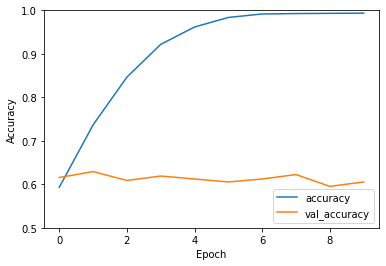

In [9]:
# compile model, improving accuracy
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on validation set
history = model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, batch_size = 128,
                         validation_data = (val_images, one_hot_val_labels), verbose = 0)

# evaluating the model
plt.figure(figsize = (6, 4))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "lower right")
val_loss, val_acc = model.evaluate(val_images, one_hot_val_labels, verbose = 2)
print("val accuracy:", val_acc)

In [10]:
# evaluating the model's performance on test set (unseen data)
test_loss, test_acc = model.evaluate(test_images, one_hot_test_labels, verbose = 2)
print("test accuracy:", test_acc)

10/10 - 1s - 62ms/step - accuracy: 0.6531 - loss: 1.1041
test accuracy: 0.6530612111091614


## Improving model
### Reducing complexity of model
From the previous model, it is seen that the model was overfitted by epoch 5. A dropout rate for regularisation will be used. A dropout rate of 0.2 for regularisation. After checking that it is beneficial to the training, an attempt can be made to find the best dropout rate to be used.

**insights**: it is noted that the loss has improved with a dropout rate. The test accuracy is also seen to improve, suggesting that the dropout rate has improved the model.

In [11]:
## MODIFIED EXISTING BASE MODEL
model = Sequential()
# creating stack of Conv2D and MaxPooling2D
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
# using dropout for regularisation (reduces overfitting)
model.add(Dropout(0.2))
# output layer with softmax
model.add(Dense(2, activation = "softmax"))

10/10 - 1s - 63ms/step - accuracy: 0.6531 - loss: 1.1495
val accuracy: 0.6530612111091614


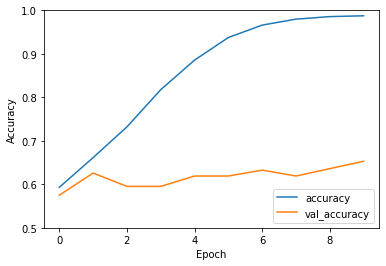

In [12]:
# compile model, improving accuracy
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on validation set
history = model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, batch_size = 128,
                    validation_data = (val_images, one_hot_val_labels), verbose = 0)

# evaluating the model
plt.figure(figsize = (6, 4))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "lower right")
val_loss, val_acc = model.evaluate(val_images, one_hot_val_labels, verbose = 2)
print("val accuracy:", val_acc)

In [13]:
# evaluating the model's performance on test set (unseen data)
test_loss, test_acc = model.evaluate(test_images, one_hot_test_labels, verbose = 2)
print("test accuracy:", test_acc)

10/10 - 1s - 63ms/step - accuracy: 0.7007 - loss: 0.8884
test accuracy: 0.7006802558898926


### Modifying dynamics of training process - early stopping
To enable early stopping, ```patience``` will be added. This is to combat the issue where the model is seen to be overfitted too early. Early stopping monitors a chosen metric ```loss``` and stops training when the model has stopped improving. This minimises loss.

**insights**: it is noted that the loss has improved significantly with the addition of early stopping. The test accuracy is also seen to improve, suggesting that the early stopping has improved the model.

In [14]:
## EXISTING BASE MODEL
model = Sequential()
# creating stack of Conv2D and MaxPooling2D
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
# output layer with softmax
model.add(Dense(2, activation = "softmax"))

10/10 - 1s - 87ms/step - accuracy: 0.5918 - loss: 0.7171
val accuracy: 0.5918367505073547


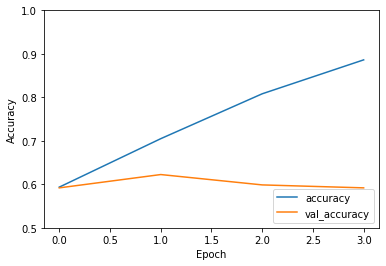

In [15]:
# adding callback for early stopping
callback = keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 2)

# compile model, improving accuracy
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on validation set
history = model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, batch_size = 128,
                         validation_data = (val_images, one_hot_val_labels), verbose = 0, callbacks = [callback])

# evaluating the model
plt.figure(figsize = (6, 4))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "lower right")
val_loss, val_acc = model.evaluate(val_images, one_hot_val_labels, verbose = 2)
print("val accuracy:", val_acc)

In [16]:
# evaluating the model's performance on test set (unseen data)
test_loss, test_acc = model.evaluate(test_images, one_hot_test_labels, verbose = 2)
print("test accuracy:", test_acc)

10/10 - 1s - 62ms/step - accuracy: 0.6701 - loss: 0.6212
test accuracy: 0.6700680255889893


#### Trying different dropout rates
As the dropout rate corresponds to how regularised the model is, the next step is to note which dropout rate provides the best model that overfits at a slower rate. The rates to be chosen will be between 0.1 and 0.9 to prevent underfitting and overfitting.

#### Trying different patience values
As the addition of early stopping significantly reduced the loss value, it is recognised that trying different patience values between 2 to 4 for early stopping can help determine the optimal setting for the model's training to also prevent underfitting and overfitting.

**Insights**: based off the output, the dropout rate of 0.7 produced the best results with a testing accuracy of 70% with the lowest loss value.

In [ ]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
patiences = [2, 3, 4]
histories_list = []

# looping through dropout rates
for dropout_rate in dropout_rates:
    for patience in patiences:
        # same modified base model
        model = Sequential()
        # creating stack of Conv2D and MaxPooling2D
        model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1))) # lowered filters
        model.add(MaxPooling2D((2, 2)))

        # unrolling output to 1D
        model.add(Flatten())
        model.add(Dense(128, activation = "relu"))
        # using dropout for regularisation (reduces overfitting)
        model.add(Dropout(dropout_rate))
        # output layer with softmax
        model.add(Dense(2, activation = "softmax"))

        # adding callback for early stopping
        callback = keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = patience)
        # compile model, improving accuracy
        model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
        # train model, validating on validation set (reducing epoch size)
        history = model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, batch_size = 128,
                            validation_data = (val_images, one_hot_val_labels), verbose = 0, callbacks = [callback])

        print("\nDropout rate:", dropout_rate, ", Patience;", patience)
        val_loss, val_acc = model.evaluate(val_images, one_hot_val_labels, verbose = 2)
        print("val accuracy:", val_acc)
        # evaluating the model's performance on test set (unseen data)
        test_loss, test_acc = model.evaluate(test_images, one_hot_test_labels, verbose = 2)
        print("test accuracy:", test_acc)
        histories_list.append(history)


Dropout rate: 0.1 , Patience; 2
10/10 - 1s - 86ms/step - accuracy: 0.6361 - loss: 0.7382
val accuracy: 0.6360543966293335
10/10 - 1s - 73ms/step - accuracy: 0.6429 - loss: 0.6230
test accuracy: 0.6428571343421936

Dropout rate: 0.1 , Patience; 3
10/10 - 1s - 79ms/step - accuracy: 0.6361 - loss: 0.8180
val accuracy: 0.6360543966293335
10/10 - 1s - 72ms/step - accuracy: 0.6871 - loss: 0.6492
test accuracy: 0.6870748400688171

Dropout rate: 0.1 , Patience; 4
10/10 - 1s - 75ms/step - accuracy: 0.6497 - loss: 1.1223
val accuracy: 0.6496598720550537
10/10 - 1s - 74ms/step - accuracy: 0.6599 - loss: 0.8652
test accuracy: 0.6598639488220215

Dropout rate: 0.2 , Patience; 2
10/10 - 2s - 172ms/step - accuracy: 0.5952 - loss: 0.6839
val accuracy: 0.5952380895614624
10/10 - 2s - 166ms/step - accuracy: 0.6905 - loss: 0.5527
test accuracy: 0.6904761791229248

Dropout rate: 0.2 , Patience; 3
10/10 - 2s - 165ms/step - accuracy: 0.5748 - loss: 0.6839
val accuracy: 0.5748299360275269
10/10 - 2s - 159ms

In [ ]:
# plotting results to evaluate
plt.figure(figsize = (12, 10))
for i, dropout_rate in enumerate(dropout_rates):
    for j, patience in enumerate(patiences):
        label_a = f"Acc - DR: ({dropout_rate}), P:({patience})"
        label_va = f"V. Acc - DR: ({dropout_rate}), P:({patience})"
        plt.plot(histories_list[i*len(patiences)+j].history["accuracy"], label = label_a)
        plt.plot(histories_list[i*len(patiences)+j].history["val_accuracy"], label = label_va)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "upper left")
plt.show()

### Modifying dynamics of training process
#### Running best dropout rate with early stopping
From the previous run, it is recognised that the dropout rate of 0.7 had the highest test accuracy of 70.1% with the lowest loss of 0.56. As such a run solely on dropout rate 0.7 will be done for a cleaner visual representation of the model's performance.

In [17]:
## MODIFIED EXISTING BASE MODEL
model = Sequential()
# creating stack of Conv2D and MaxPooling2D
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
# using dropout for regularisation (reduces overfitting)
model.add(Dropout(0.7))
# output layer with softmax
model.add(Dense(2, activation = "softmax"))

10/10 - 1s - 67ms/step - accuracy: 0.6224 - loss: 0.6809
val accuracy: 0.6224489808082581


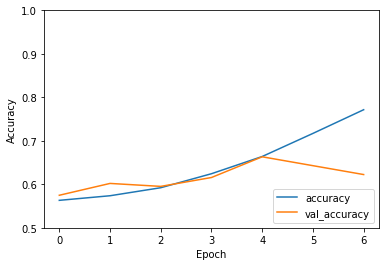

In [31]:
# adding callback for early stopping
callback = keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 2)

# compile model, improving accuracy
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on validation set
history = model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, batch_size = 128,
                    validation_data = (val_images, one_hot_val_labels), verbose = 0, callbacks = [callback])

# evaluating the model
plt.figure(figsize = (6, 4))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "lower right")
val_loss, val_acc = model.evaluate(val_images, one_hot_val_labels, verbose = 2)
print("val accuracy:", val_acc)

In [19]:
# evaluating the model's performance on test set (unseen data)
test_loss, test_acc = model.evaluate(test_images, one_hot_test_labels, verbose = 2)
print("test accuracy:", test_acc)

10/10 - 1s - 72ms/step - accuracy: 0.6905 - loss: 0.8625
test accuracy: 0.6904761791229248


## Dataset Citation
- Dataset: Awsaf (2021) CBIS-DDSM: Breast Cancer Image Dataset, Kaggle. Available at: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset
- Licencing: Creative commons (no date) CC BY-SA 3.0 Deed | Attribution-ShareAlike 3.0 Unported | Creative Commons. Available at: https://creativecommons.org/licenses/by-sa/3.0/

# IGNORE BELOW
The following were failed attempts

#### Increasing complexity of neural network
To attempt to make the model perform better, the Dense layers will have a higher number of neurons, instead of adding 2 Dense layers of 128 neurons.

### Improving with additional layers

In [ ]:
twoLayer_model = Sequential()

# first convolutional layer
twoLayer_model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
twoLayer_model.add(MaxPooling2D((2, 2)))

# second convolutional layer
twoLayer_model.add(Conv2D(64, (3, 3), activation = "relu"))
twoLayer_model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
twoLayer_model.add(Flatten())
twoLayer_model.add(Dense(128, activation = "relu"))
# using dropout for regularisation (reduces overfitting)
twoLayer_model.add(Dropout(0.5))
# output layer with softmax
twoLayer_model.add(Dense(2, activation = "softmax"))

In [ ]:
# compile model, improving accuracy
twoLayer_model.compile(optimizer = "Nadam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on test set
history = twoLayer_model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, validation_data = (test_images, one_hot_test_labels))

In [ ]:
threeLayer_model = Sequential()

# first convolutional layer
threeLayer_model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
threeLayer_model.add(MaxPooling2D((2, 2)))

# second convolutional layer
threeLayer_model.add(Conv2D(64, (3, 3), activation = "relu"))
threeLayer_model.add(MaxPooling2D((2, 2)))

# third convolutional layer
threeLayer_model.add(Conv2D(128, (3, 3), activation = "relu"))
threeLayer_model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
threeLayer_model.add(Flatten())
threeLayer_model.add(Dense(128, activation = "relu"))
# using dropout for regularisation (reduces overfitting)
threeLayer_model.add(Dropout(0.5))
# output layer with softmax
threeLayer_model.add(Dense(2, activation = "softmax"))

In [ ]:
# compile model, improving accuracy
threeLayer_model.compile(optimizer = "Nadam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on test set
history = threeLayer_model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, validation_data = (test_images, one_hot_test_labels))

### Hyperparameter tuning
To conduct hyperparameter tuning, it is beneficial to wrap the model in a function. This makes it scikit-learn compatable as there will be methods like Grid Search and Randomised Search to help optimise the performance of the neural network.

As more runs will be done, adding verbose = 2 makes the information printed a single line.

In [ ]:
# defining model as a function
def create_3Layer_model(dropout_rate = 0.5, **kwargs):
    model = Sequential()

    # first convolutional layer
    model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
    model.add(MaxPooling2D((2, 2)))

    # second convolutional layer
    model.add(Conv2D(64, (3, 3), activation = "relu"))
    model.add(MaxPooling2D((2, 2)))

    # third convolutional layer
    model.add(Conv2D(128, (3, 3), activation = "relu"))
    model.add(MaxPooling2D((2, 2)))

    # unrolling output to 1D
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    # using dropout for regularisation (reduces overfitting)
    model.add(Dropout(dropout_rate))
    # output layer with softmax
    model.add(Dense(2, activation = "softmax"))
    
    # compile model, improving accuracy
    model.compile(optimizer = "Nadam", loss = "categorical_crossentropy", metrics = ["accuracy"])
    # train model, validating on test set
    history = model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, validation_data = (test_images, one_hot_test_labels))
    
    return model, history

#### Conducting Grid Search
[modify] involves defining a grid of hyperparameter values and training the model for each combination. It's a brute-force approach that explores a predefined set of hyperparameter values.

In [ ]:
# creating the Keras classifier
model_for_grid = KerasClassifier(build_fn = create_3Layer_model, epochs = 10, batch_size = 32, verbose = 2)

# defining hyperparameters
parameter = {
    'dropout_rate': [0.2, 0.3, 0.4, 0.5]
}

# performing grid search - 5 fold grid search
grid_search = GridSearchCV(estimator = model_for_grid, param_grid = parameter)
grid_result = grid_search.fit(augmented_images, one_hot_aug_train_labels)

#### Conducting Random Search
[modify] randomly samples hyperparameter values from predefined ranges. It is more efficient than grid search and can be effective in high-dimensional spaces.

In [ ]:
from scipy.stats import uniform

# creating the Keras classifier
model_for_rand = KerasClassifier(build_fn = create_3Layer_model, epochs = 10, batch_size = 32, verbose = 2)

# defining hyperparameters
parameter = {
    'dropout_rate': uniform(0.2, 0.5)
}

# performing grid search - 5 fold grid search
rand_search = RandomizedSearchCV(estimator = model_for_rand, param_distributions = parameter)
rand_result = rand_search.fit(augmented_images, one_hot_aug_train_labels)